In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Mounted at /content/drive
/content/drive/My Drive/ann challenge


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()

## Auxiliary functions

In [ ]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [ ]:
def plot_history(history, log_scale: bool = False) -> None:
  mae = history['mae']
  val_mae = history['val_mae']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmin(val_loss)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')

  if log_scale:
      plt.semilogy(loss, label='Training MSE', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation MSE', color='#4D61E2')
  else:
      plt.plot(loss, label='Training MSE', color='#ff7f0e')
      plt.plot(val_loss, label='Validation MSE', color='#4D61E2')

  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')

  if log_scale:
     plt.semilogy(mae, label='Training MAE', color='#ff7f0e')
     plt.semilogy(val_mae, label='Validation MAE', color='#4D61E2')
  else:
    plt.plot(mae, label='Training MAE', color='#ff7f0e')
    plt.plot(val_mae, label='Validation MAE', color='#4D61E2')

  plt.plot(best_epoch, history['val_mae'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
def plot_data_and_target(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='data', linewidth=2)
  plt.plot(indexes[len(data):], target, label='target', linewidth=2)

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

In [ ]:
def plot_data_and_target_2_batches(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='original sequence', linewidth=2)
  plt.plot(indexes[len(data)-1:len(data)+telescope], np.concatenate((data[-1:],target[:telescope]), axis=0), label='prediction (0-9)', linewidth=2)
  plt.plot(indexes[len(data)+telescope-1:], target[-telescope-1:], label='prediction (10-18)', linewidth=2, color='olivedrab')

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build the model

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = y_train.shape[1:]        # Output shape for the model
batch_size = 512                        # Batch size for training
epochs = 200                            # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 512
Input Shape: (200, 1)
Output Shape: (9, 1)


In [ ]:
initializer = tf.keras.initializers.HeNormal()

def build_model(input_shape, output_shape):
  # Ensure the input time steps are at least as many as the output time steps
  assert input_shape[0] >= output_shape[0]

  # Define the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')
  n_feature_maps = 16


  # BLOCK 1

  conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(input_layer)
  conv_y = tfkl.BatchNormalization()(conv_y)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
  conv_z = tfkl.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_1 = tfkl.add([shortcut_y, conv_z])
  output_block_1 = tfkl.Activation('relu')(output_block_1)

  # BLOCK 2

  conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(output_block_1)
  conv_y = tfkl.BatchNormalization()(conv_y)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = tfkl.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_2 = tfkl.add([shortcut_y, conv_z])
  output_block_2 = tfkl.Activation('relu')(output_block_2)

  # bidirectional layer
  x = tfkl.Bidirectional(tfkl.GRU(32))(output_block_2)

  # dense
  x = tfkl.Dense(units=128, kernel_initializer=initializer)(x)
  x = tfkl.Activation('swish')(x)
  x = tfkl.Dropout(0.2)(x)

  # adjust output size to match labels
  output_layer = tfkl.Dense(9, activation='linear')(x)

  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='ResNet2B_BiLSTM_CONV1D_with_stride_model')

  # Compile the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3), metrics=['mae'])

  return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()

Model: "ResNet2B_BiLSTM_CONV1D_with_stride_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 200, 16)              96        ['input_layer[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 200, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 200, 16)              0

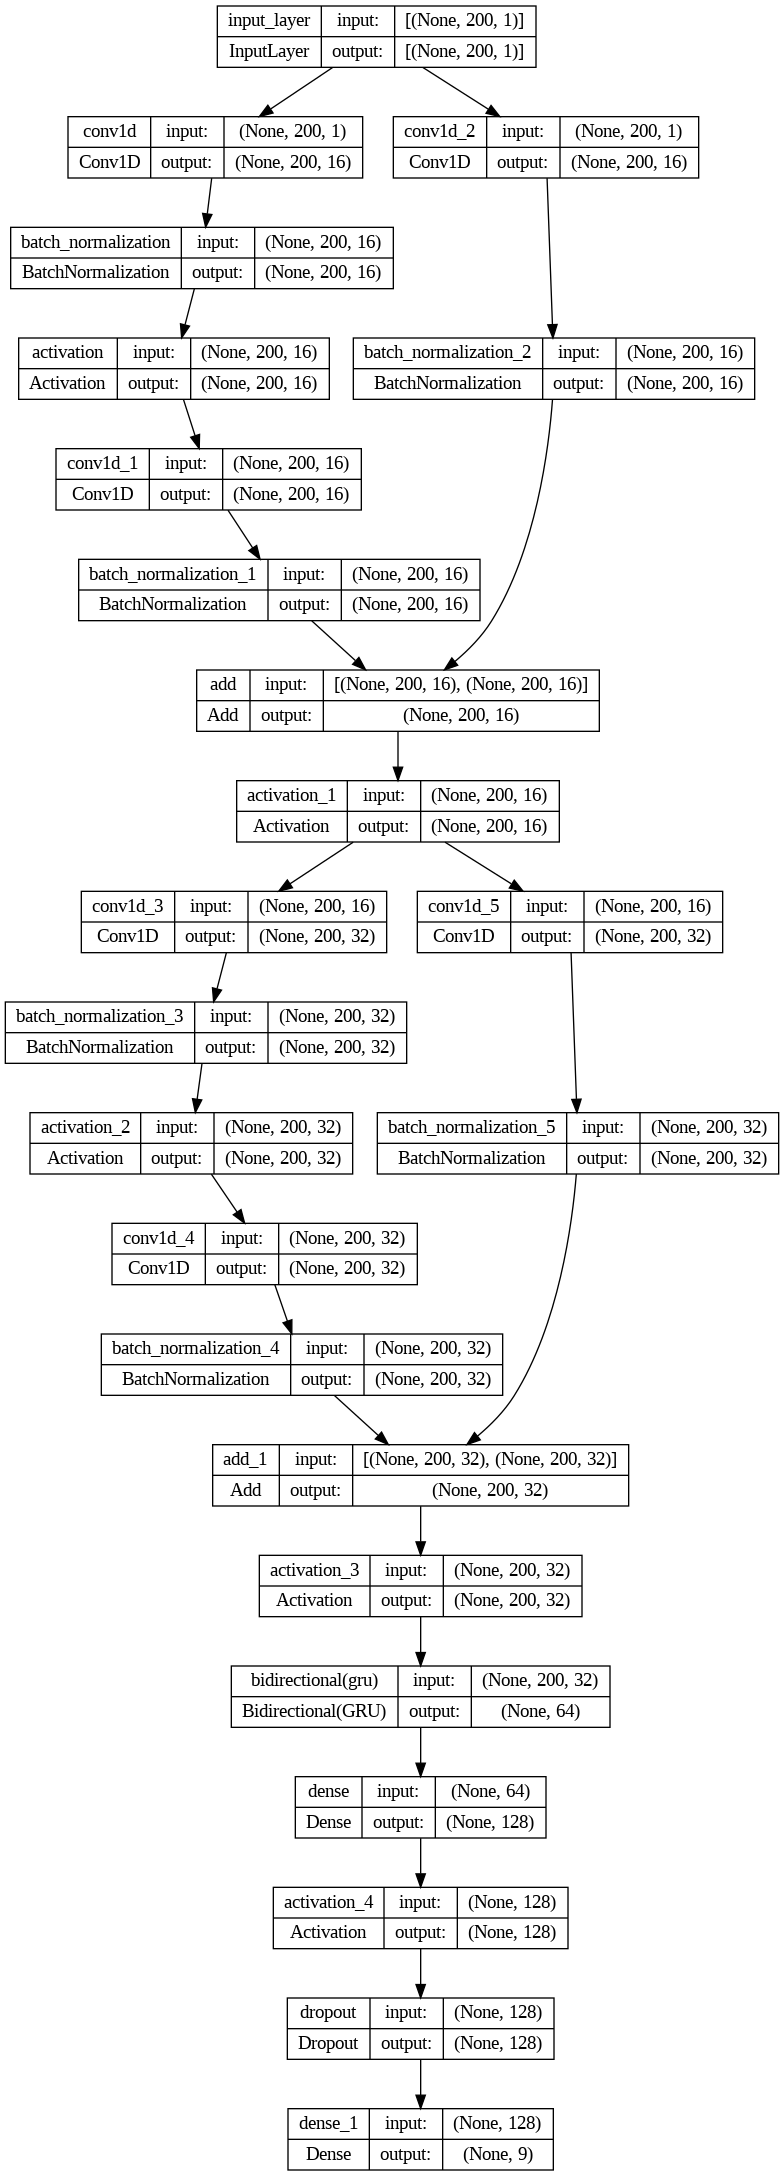

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
lr_patience = 10
es_patience = 20
callbacks = [
    tfk.callbacks.TerminateOnNaN(),
    tfk.callbacks.ReduceLROnPlateau('val_loss', patience=lr_patience, factor=0.3, min_lr=1e-5, verbose=1),
    tfk.callbacks.EarlyStopping('val_loss', patience=es_patience, restore_best_weights=True, verbose=1)
]

## Train model

In [ ]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
).history

Epoch 1/200
302/302 [==============================] - 23s 45ms/step - loss: 0.0306 - mae: 0.1198 - val_loss: 0.0809 - val_mae: 0.2286 - lr: 0.0010
Epoch 2/200
302/302 [==============================] - 12s 41ms/step - loss: 0.0151 - mae: 0.0869 - val_loss: 0.0166 - val_mae: 0.0947 - lr: 0.0010
Epoch 3/200
302/302 [==============================] - 12s 41ms/step - loss: 0.0137 - mae: 0.0818 - val_loss: 0.0116 - val_mae: 0.0724 - lr: 0.0010
Epoch 4/200
302/302 [==============================] - 13s 42ms/step - loss: 0.0128 - mae: 0.0783 - val_loss: 0.0116 - val_mae: 0.0732 - lr: 0.0010
Epoch 5/200
302/302 [==============================] - 13s 42ms/step - loss: 0.0123 - mae: 0.0761 - val_loss: 0.0110 - val_mae: 0.0697 - lr: 0.0010
Epoch 6/200
302/302 [==============================] - 12s 41ms/step - loss: 0.0119 - mae: 0.0745 - val_loss: 0.0106 - val_mae: 0.0687 - lr: 0.0010
Epoch 7/200
302/302 [==============================] - 13s 42ms/step - loss: 0.0114 - mae: 0.0728 - val_loss: 0.

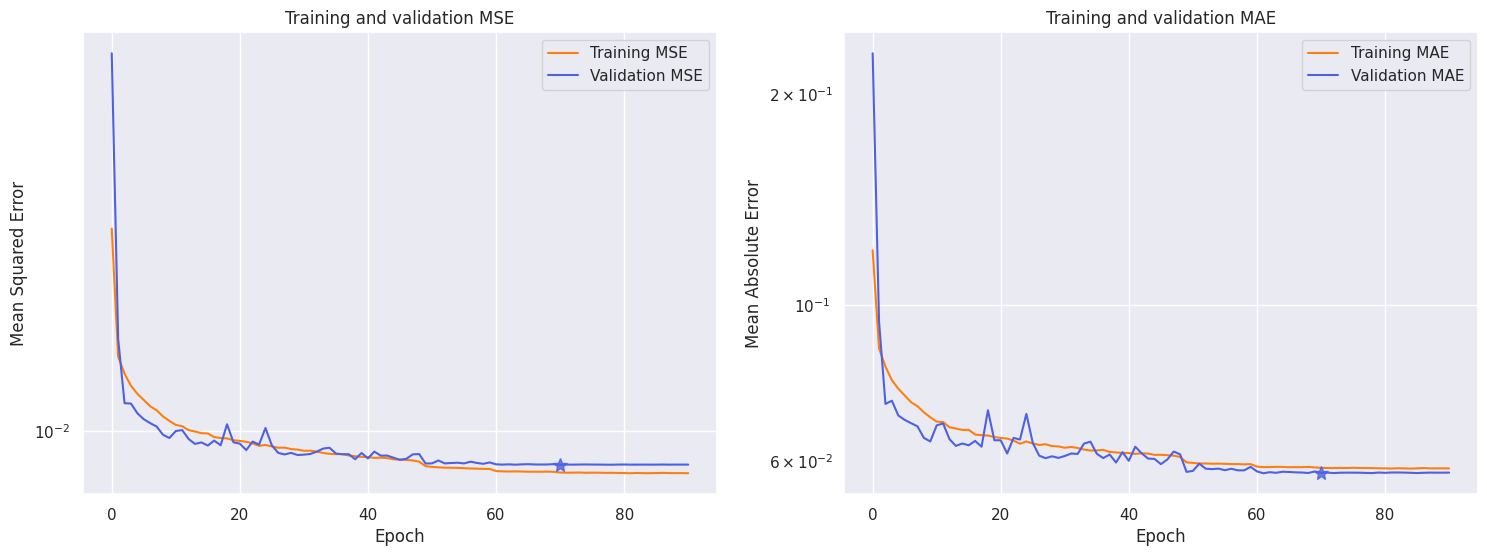

In [ ]:
plot_history(history, log_scale=True)

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 5s 9ms/step - loss: 0.0083 - mae: 0.0578
Mean Squared Error: 0.008277248591184616
Mean Absolute Error: 0.05777740478515625


In [ ]:
# Save the trained model
model.save('models/' + model.name)
del model

## Autoregressive Model

In [ ]:
model = tfk.models.load_model('models/ResNet2B_CONV1D_BiGRU_with_stride_model')

In [ ]:
# telescope is the number of timestamps that the model predicts
telescope = 9
# samples to predict is the total number of timestamps that we want to predict with the autoregressor model. This MUST be a factor of the telescope
samples_to_predict = telescope * 2
# test_sequences is the data we use to test the model. This will have to be changed with the Codalab data when submitting if we want to use this autoregressor model.
test_sequences = X_val[0:60]
sequences = np.copy(test_sequences)

i = 0
while i*telescope < samples_to_predict:
  pred = model.predict(sequences[:,:])
  for j in range(len(sequences)):
    for z in range(len(pred[j])):
      sequences[j] = np.delete(np.append(sequences[j], pred[j][z]), 0).reshape(-1, 1)
  i += 1

2/2 [==============================] - 0s 60ms/step


In [ ]:
# prediction inspection
index = np.random.randint(len(test_sequences))
# index = 37

In [ ]:
# plot_data_and_target(test_sequences[index], sequences[index,-samples_to_predict:])

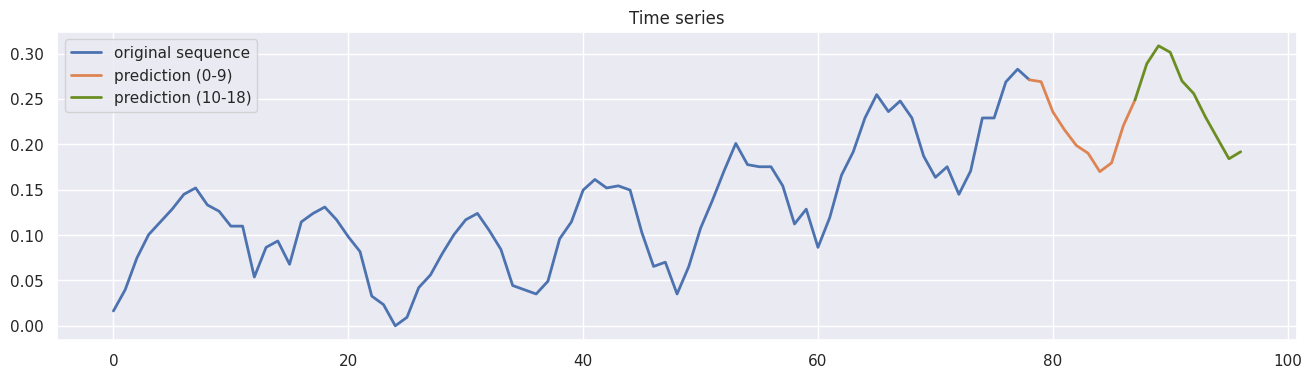

In [ ]:
# this plot function identifies only two prediction batches
# to plot different predictions amounts, uncomment the previous cell and modify the autoregressive code
plot_data_and_target_2_batches(test_sequences[index], sequences[index,-samples_to_predict:])